# Анализ сервиса аренды самокатов GoFast

Необходимо выполнить исследование в качестве аналитика популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

В нашем распоряжении имеются три набора данных:

1. **Пользователи** (users_go.csv):
- **user_id** — уникальный идентификатор пользователя.
- **name** — имя пользователя.
- **age** — возраст пользователя.
- **city** — город пользователя.
- **subscription_type** — тип подписки (free или ultra).
2. **Поездки** (rides_go.csv):
- **user_id** — уникальный идентификатор пользователя.
- **distance** — расстояние поездки в метрах.
- **duration** — продолжительность поездки в минутах.
- **date** — дата поездки.
3. **Подписки** (subscriptions_go.csv):
- **subscription_type** — тип подписки.
- **minute_price** — стоимость минуты поездки.
- **start_ride_price** — стоимость начала поездки.
- **subscription_fee** — ежемесячная стоимость подписки.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
План действий:
- Предобработка данных: удаление пропусков и дубликатов, преобразование форматов данных.
- Исследовательский анализ данных (EDA): анализ возраста пользователей, их распределения по городам, подписок, продолжительности поездок и других показателей.
- Проверка гипотез: проверка гипотез о продолжительности поездок, среднем расстоянии поездок и помесячной выручке от пользователей с подпиской и без неё.
- Дополнительные задачи: определение минимального количества промокодов для акции с учётом заданной вероятности, оценка вероятности открытия push-уведомлений с помощью аппроксимации биномиального распределения нормальным.

Целью данного анализа является получение ценной информации для компании GoFast, которая поможет в оптимизации маркетинговых стратегий, управлении подписками и улучшении обслуживания пользователей.

## Загрузка и просмотр данных

В основных данных есть информация о пользователях, их поездках и подписках. Загрузим все датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [1]:
# Подключение всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import binom
from scipy.stats import norm

In [2]:
users = pd.read_csv('users_go.csv')

users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


`users` (пользователи):
- **user_id:** уникальный идентификатор пользователя (целое число).
- **name:** имя пользователя (строка).
- **age:** возраст пользователя (целое число).
- **city:** город, где проживает пользователь (строка).
- **subscription_type:** тип подписки пользователя — free или ultra (строка)

In [4]:
rides = pd.read_csv('rides_go.csv')

rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


`rides` (поездки):
- **user_id:** уникальный идентификатор пользователя, который совершил поездку (целое число).
- **distance:** расстояние поездки в метрах (вещественное число).
- **duration:** продолжительность поездки в минутах (вещественное число).
- **date:** дата поездки (строка, которую можно преобразовать в формат даты для удобства анализа).

In [6]:
subscriptions = pd.read_csv('subscriptions_go.csv')
    
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


`subscriptions` (подписки):
- **subscription_type:** тип подписки — free или ultra (строка).
- **minute_price:** стоимость одной минуты поездки (целое число).
- **start_ride_price:** стоимость начала поездки (целое число).
- **subscription_fee:** стоимость подписки в месяц (целое число).

Таким образом, мы загрузили и изучили исходные данные.

## Предобработка данных

### Работа со столбцами

Приведём столбец `date` к типу даты pandas.

In [8]:
# Преобразование столбца 'date' в формат даты
rides['date'] = pd.to_datetime(rides['date'])

# Просмотр первых 5 строк столбца для проверки
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Создадим новый столбец с номером месяца на основе столбца `date`.

In [9]:
# Создание нового столбца с номером месяца
rides['month'] = rides['date'].dt.month

# Просмотр первых 5 строк только для столбцов 'date' и 'month'
rides[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


Посмотрим, за какой период у нас имеются данные и как они распределены за этот период.

In [10]:
# Проверим минимальную и максимальную дату в данных
min_date = rides['date'].min()
max_date = rides['date'].max()

print(f"Данные о поездках за период: с {min_date} по {max_date}")

Данные о поездках за период: с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


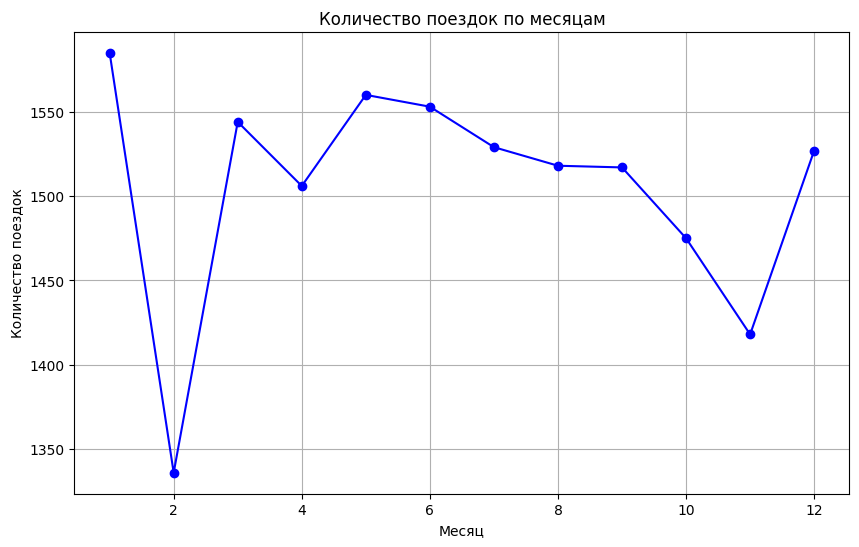

In [11]:
# Посчитаем количество поездок по месяцам
rides_per_month = rides.groupby('month')['date'].count()

# Построим линейную диаграмму количества поездок по месяцам
plt.figure(figsize=(10, 6))
plt.plot(rides_per_month.index, rides_per_month.values, marker='o', linestyle='-', color='b')
plt.title('Количество поездок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

Исходя из предоставленного графика и диапазона дат, данные о поездках охватывают период с 1 января 2021 года по 30 декабря 2021 года. На линейной диаграмме видно, как изменялось количество поездок по месяцам в течение этого года.

### Поиск пропусков

In [12]:
# Проверка пропусков в каждом датафрейме
missing_users = users.isnull().sum()
missing_rides = rides.isnull().sum()
missing_subscriptions = subscriptions.isnull().sum()

# Вывод количества пропусков в каждом датафрейме
print("Пропуски в датафрейме users:")
print(missing_users)
print("\nПропуски в датафрейме rides:")
print(missing_rides)
print("\nПропуски в датафрейме subscriptions:")
print(missing_subscriptions)

Пропуски в датафрейме users:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропуски в датафрейме rides:
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропуски в датафрейме subscriptions:
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Явных пропусков не обнаружено.

### Поиск дубликатов

In [13]:
# Проверка на дубликаты в каждом датафрейме
duplicates_users = users.duplicated().sum()
duplicates_rides = rides.duplicated().sum()
duplicates_subscriptions = subscriptions.duplicated().sum()

# Вывод количества дубликатов в каждом датафрейме
print("Количество дубликатов в датафрейме users:", duplicates_users)
print("Количество дубликатов в датафрейме rides:", duplicates_rides)
print("Количество дубликатов в датафрейме subscriptions:", duplicates_subscriptions)

Количество дубликатов в датафрейме users: 31
Количество дубликатов в датафрейме rides: 0
Количество дубликатов в датафрейме subscriptions: 0


В датафрейме `users` 31 строка являются полными дублями (все значения в строке идентичны). Их лучше удалить, так как они не несут дополнительной информации и могут исказить анализ.

In [14]:
# Удаление полных дубликатов в исходном датафрейме users
users = users.drop_duplicates()

# Проверка, что дубликаты удалены
print("Количество дубликатов после удаления:", users.duplicated().sum())

Количество дубликатов после удаления: 0


Теперь проверим данные на наличие неявных дублей.

Начнем с датафрейма `users`. В нем проверим по столбцу `id`, т.к. по остальным столбцам (имя,  возраст, город и подписка) дубли возможны, это корректно.

In [15]:
# Проверка уникальности user_id
duplicate_user_ids = users['user_id'].duplicated().sum()

print("Количество повторяющихся user_id:", duplicate_user_ids)

Количество повторяющихся user_id: 0


Остальные датафреймы проверять на неявные дубли нецелесообразно. В `rides` записи могут дублироваться по `id`, т.к. пользователь может совершать несколько поездок и даже в один день, а на явные дубли мы уже выполнили проверку. В `subscriptions` всего 2 записи.

Таким образом, мы рассмотрели все возможные дубликаты.

В этом разделе мы выполнили предобработку данных: преобразовали столбец с датой, добавили новый столбец с месяцем, а так же изучили и обработали пропуски и дубликаты.

## Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

### Частота встречаемости городов

             city  user_count
0       Пятигорск         219
1    Екатеринбург         204
2  Ростов-на-Дону         198
3       Краснодар         193
4            Сочи         189
5            Омск         183
6          Тюмень         180
7          Москва         168


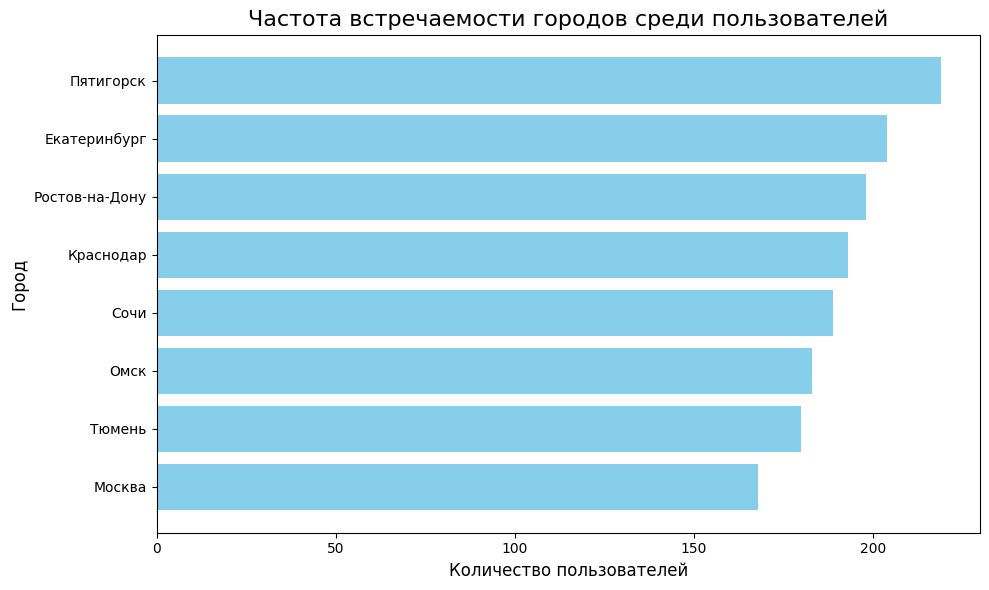

In [16]:
# Создаем таблицу частоты встречаемости городов
city_counts = users['city'].value_counts().reset_index()
city_counts.columns = ['city', 'user_count']

# Сортируем по количеству пользователей по убыванию
city_counts = city_counts.sort_values(by='user_count', ascending=False)

# Выводим таблицу для анализа
print(city_counts)

# Строим горизонтальный график с инверсией оси Y
plt.figure(figsize=(10,6))
plt.barh(city_counts['city'], city_counts['user_count'], color='skyblue')
plt.title('Частота встречаемости городов среди пользователей', fontsize=16)
plt.xlabel('Количество пользователей', fontsize=12)
plt.ylabel('Город', fontsize=12)
plt.gca().invert_yaxis()  # Инвертируем ось Y
plt.tight_layout()
plt.show()


По результатам анализа видно, что больше всего пользователей сервиса GoFast в Пятигорске — 219 человек. Далее идут крупные города: Екатеринбург (204 пользователя), Ростов-на-Дону (198 пользователей) и Краснодар (193 пользователя). Замыкают список Москва (168 пользователей) и Тюмень (180 пользователей). Интересно, что Москва не занимает лидирующие позиции по количеству пользователей, что может указывать на специфику спроса на аренду самокатов в разных регионах или уровень конкуренции.

### Соотношение пользователей с подпиской и без подписки

  subscription_type  user_count
0              free         835
1             ultra         699


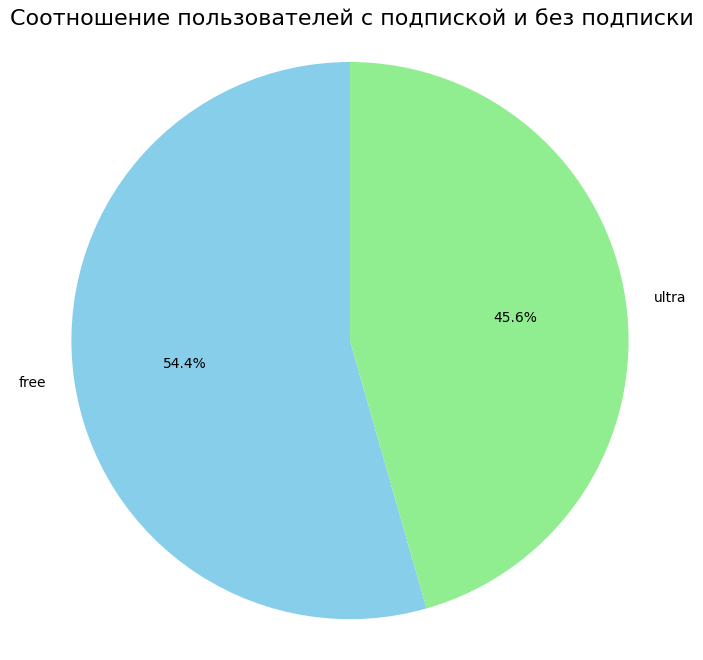

In [17]:
# Создаем таблицу частоты типов подписок
subscription_counts = users['subscription_type'].value_counts().reset_index()
subscription_counts.columns = ['subscription_type', 'user_count']

# Выводим таблицу для анализа
print(subscription_counts)

# Строим круговую диаграмму
plt.figure(figsize=(8,8))
plt.pie(subscription_counts['user_count'], labels=subscription_counts['subscription_type'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Соотношение пользователей с подпиской и без подписки', fontsize=16)
plt.axis('equal')  # Для круглой формы диаграммы
plt.show()

Соотношение пользователей с подпиской и без подписки:
- 835 пользователей (54.4%) используют сервис GoFast без подписки.
- 699 пользователей (45.6%) оформили подписку Ultra.

Это довольно равномерное распределение, что указывает на значительное количество пользователей, готовых платить за подписку ради снижения стоимости поездок. Однако большинство пользователей пока предпочитают пользоваться сервисом без подписки, оплачивая каждую поездку отдельно.

### Возраст пользователей

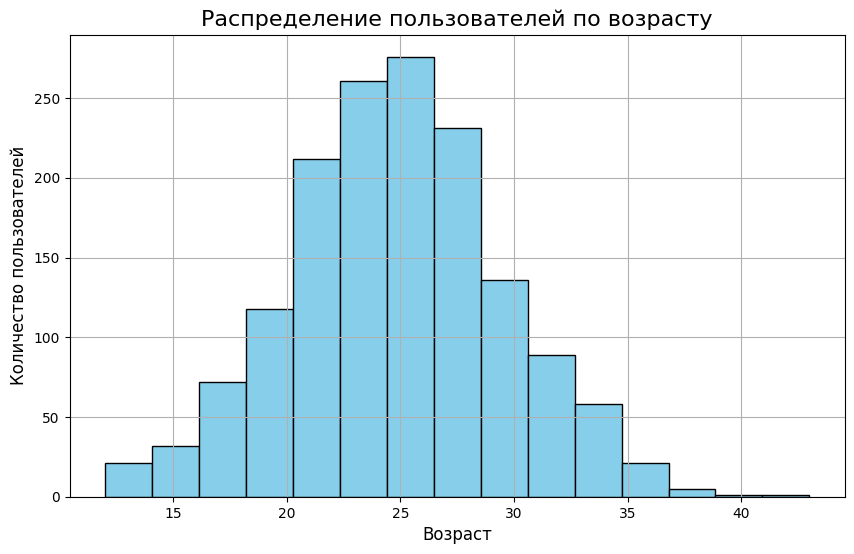

In [18]:
# Создаем таблицу частоты встречаемости возрастов
age_counts = users['age'].value_counts().reset_index()
age_counts.columns = ['age', 'user_count']

# Строим гистограмму для отображения распределения возрастов пользователей
plt.figure(figsize=(10,6))
plt.hist(users['age'], bins=15, color='skyblue', edgecolor='black')
plt.title('Распределение пользователей по возрасту', fontsize=16)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

На основе гистограммы распределения возрастов можно сделать следующие выводы:
- Основная возрастная группа пользователей — от 20 до 30 лет. В этой группе наибольшее количество пользователей, причём пик приходится на возраст 25 лет. Это может указывать на привлекательность сервиса для студентов и молодых людей. Видим меньшее количество пользователей старше 30 лет, что также отражает популярность аренды самокатов среди более молодых возрастных групп.
- Нормальное распределение: данные показывают нормальное распределение пользователей по возрасту с явным пиком в середине (около 25 лет) и снижением к обеим сторонам от этого значения.

### Расстояние, которое пользователь преодолел за одну поездку

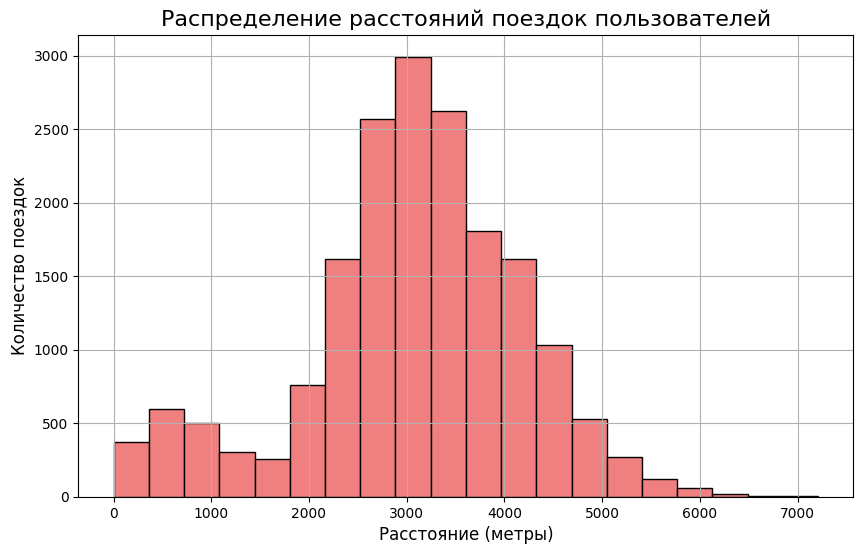

In [19]:
# Создаем таблицу частоты расстояний
distance_counts = rides['distance'].value_counts().reset_index()
distance_counts.columns = ['distance', 'ride_count']

# Строим гистограмму для отображения распределения расстояний
plt.figure(figsize=(10,6))
plt.hist(rides['distance'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Распределение расстояний поездок пользователей', fontsize=16)
plt.xlabel('Расстояние (метры)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

In [20]:
# Посмтрим на основную информацию о распределении данных
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

На основе полученной гистограммы распределения расстояний поездок пользователей можно сделать следующие выводы:
- Основное расстояние поездок: большинство пользователей преодолевают расстояние около 2000–4000 метров за одну поездку. Пик приходится примерно на 3070 метров, что соответствует стандартным городским перемещениям. Существуют поездки на более длинные дистанции (свыше 5000 метров), но таких случаев немного. Так же есть значительное количество поездок, которые выполняется на расстояние менее 2000 метров. Это говорит о том, что многие пользователи используют сервис для коротких поездок, возможно, чтобы добраться до ближайшей станции метро, торгового центра или работы.
- Распределение: видно, что большая часть поездок сосредоточена в диапазоне до 5000 метров, с резким спадом по мере увеличения расстояния. Это говорит о том, что пользователи в основном используют самокаты для коротких и средних дистанций в пределах города.

### Продолжительность поездок

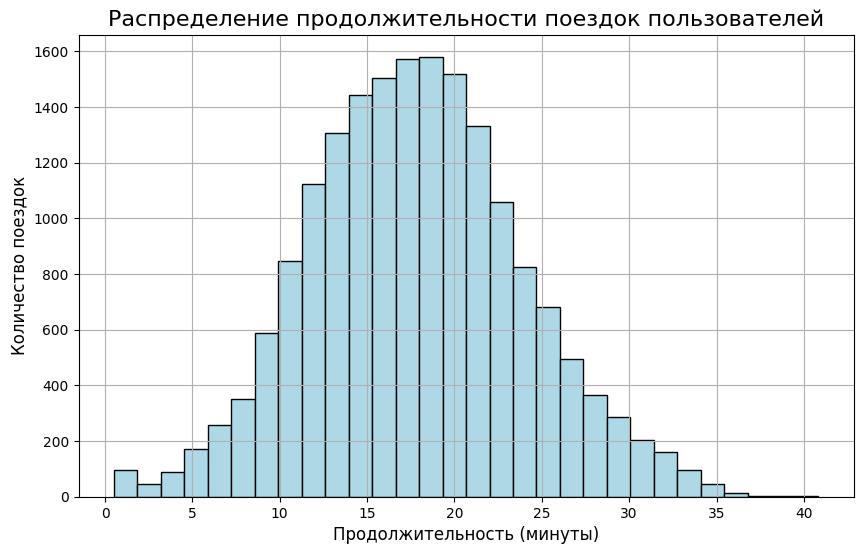

In [21]:
# Создаем таблицу частоты продолжительности поездок
duration_counts = rides['duration'].value_counts().reset_index()
duration_counts.columns = ['duration', 'ride_count']

# Строим гистограмму для отображения распределения продолжительности поездок
plt.figure(figsize=(10,6))
plt.hist(rides['duration'], bins=30, color='lightblue', edgecolor='black')
plt.title('Распределение продолжительности поездок пользователей', fontsize=16)
plt.xlabel('Продолжительность (минуты)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

In [22]:
# Посмтрим на основную информацию о распределении данных
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Заметим, что на графике есть странный пик со значениями около нуля (минимальная длительность поездки 30 секунд). Скорее всего, у пользователей что-то пошло не так (например, какая-то проблема с самокатом), и они закончили поездку раньше желаемого времени. Такие данные стоит рассмотреть, как аномальные и удалить. 

Порог в 1 минуту (60 секунд) может быть разумным минимальным значением для анализа. Например, за минуту пользователь может успеть проехать короткое расстояние, даже если это была реальная, но быстрая поездка. Поездки короче 1 минуты, вероятнее всего, можно считать аномальными, так как они не отражают типичное поведение пользователей, а могут свидетельствовать о технических проблемах или случайном завершении поездки.

In [23]:
# Подсчитываем количество поездок с продолжительностью меньше 1 минуты
num_short_rides = rides[rides['duration'] < 1].shape[0]

# Выводим количество таких поездок
print(f"Количество поездок с продолжительностью меньше 1 минуты: {num_short_rides}")

# Фильтруем данные, удаляя поездки, которые длились менее 1 минуты (60 секунд)
rides = rides[rides['duration'] >= 1]

# Выводим минимальное значение продолжительности после фильтрации
print(f"Минимальная продолжительность поездки после фильтрации: {rides['duration'].min()}")

Количество поездок с продолжительностью меньше 1 минуты: 95
Минимальная продолжительность поездки после фильтрации: 2.0356324681963884


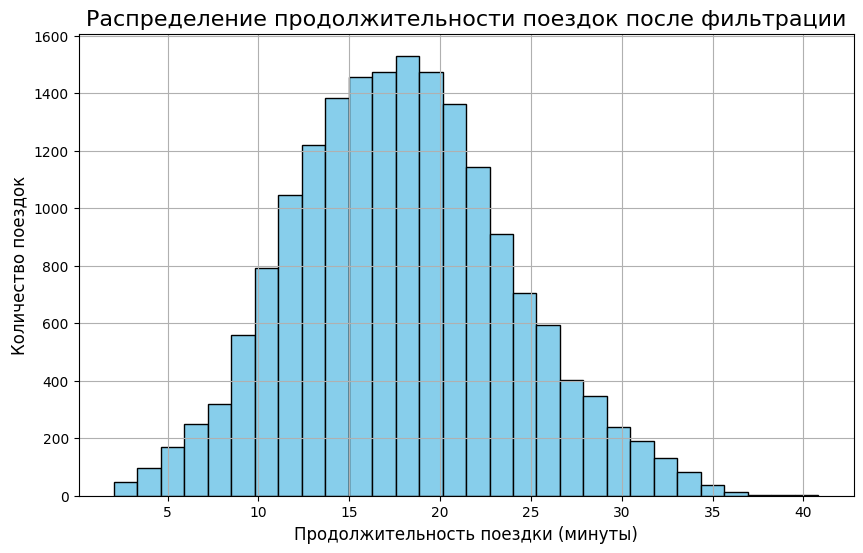

In [24]:
# Строим обновлённый график продолжительности поездок
plt.figure(figsize=(10,6))
plt.hist(rides['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение продолжительности поездок после фильтрации', fontsize=16)
plt.xlabel('Продолжительность поездки (минуты)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True)
plt.show()

In [25]:
# Посмтрим на основную информацию о распределении отфильтрованных данных
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

На основе полученной гистограммы можно сделать следующие выводы:
- Нормальное распределение: продолжительность поездок пользователей GoFast распределена нормально, с пиком на интервале 15-20 минут. Это говорит о том, что большинство пользователей тратят примерно это время на одну поездку.
- Основная продолжительность поездок: наиболее частая продолжительность поездок — от 10 до 25 минут. Это может указывать на то, что пользователи совершают поездки на самокатах на короткие или средние расстояния, которые требуют примерно этого времени. Что подтверждает предыдущие выводы о расстроянии.
- Редкость долгих поездок: поездки продолжительностью более 30 минут встречаются редко, что свидетельствует о том, что сервис GoFast чаще используется для коротких перемещений по городу, а не для длительных поездок, что тоже подтвержает предыдущие выводы.

В этом разделе мы провели исследовательский аналих данных и получили следующую информацию о пользователях и их поездках:
1. Географическое распределение пользователей: наибольшее количество пользователей сосредоточено в Пятигорске, Екатеринбурге и Ростове-на-Дону. Москва, несмотря на свои размеры, не входит в топ городов по числу пользователей, что может указывать на особенности спроса в различных регионах или конкуренцию по спросу.
2. Подписки: почти поровну разделены пользователи с подпиской Ultra и без неё. Тем не менее, большинство пользователей (54%) пока предпочитают пользоваться сервисом без подписки, что указывает на потенциал для дальнейшего продвижения подписки среди клиентов.
3. Возраст пользователей: основная возрастная группа пользователей — от 20 до 30 лет, с пиком в 25 лет. Это молодая аудитория, активно использующая сервис для передвижений по городу.
4. Расстояние поездок: большинство поездок совершается на расстояние от 2000 до 4000 метров, с пиком около 3000 метров. Это подтверждает, что пользователи чаще всего используют самокаты для коротких или средних перемещений.
5. Продолжительность поездок: распределение продолжительности поездок имеет нормальный характер, и основное время поездок — от 10 до 25 минут. Пик приходится на поездки продолжительностью 15-20 минут, что также свидетельствует о популярности коротких поездок среди пользователей.

## Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [26]:
# Объединяем таблицу users и rides по полю 'user_id'
users_rides = pd.merge(users, rides, on='user_id', how='inner')

# Объединяем полученный датафрейм с таблицей subscriptions по полю 'subscription_type'
full_data = pd.merge(users_rides, subscriptions, on='subscription_type', how='inner')

# Выводим результат объединения для проверки
full_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [27]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Объединение данных прошло успешно.

### Создание дополнительных датафреймов

Создадим ещё два отдельных датафрейма:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [28]:
# Датафрейм с пользователями без подписки
free_users_data = full_data[full_data['subscription_type'] == 'free']

# Датафрейм с пользователями с подпиской (Ultra)
ultra_users_data = full_data[full_data['subscription_type'] == 'ultra']

# Выводим по 5 строк из каждого для проверки
print("Данные о пользователях без подписки:")
display(free_users_data.head())

print("\nДанные о пользователях с подпиской:")
display(ultra_users_data.head())

Данные о пользователях без подписки:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0



Данные о пользователях с подпиской:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Отлично, создали.

### Информация о расстоянии и времени поездок

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

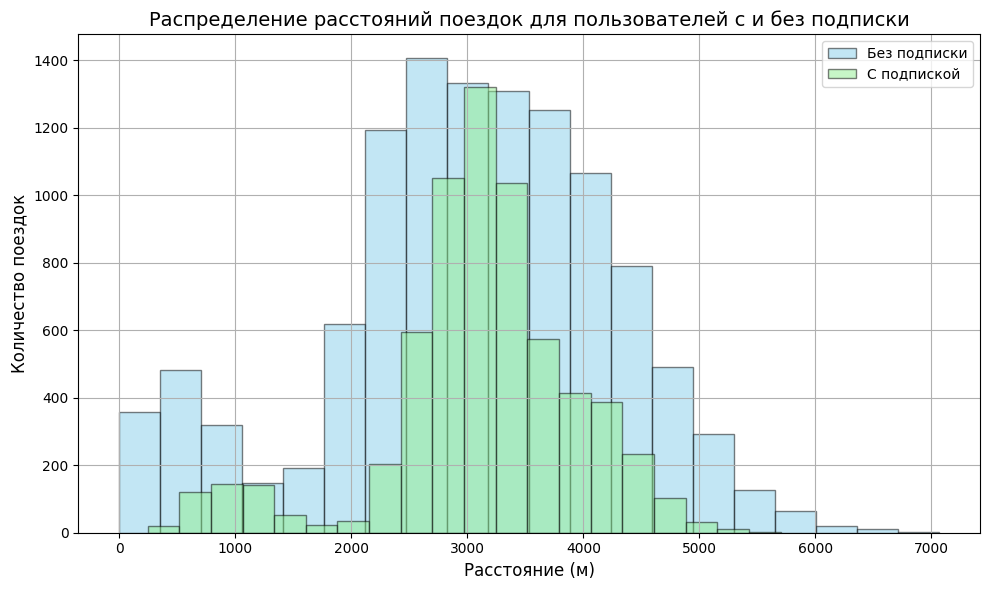

In [29]:
# Визуализация данных о расстоянии поездок на одном графике для обеих групп
plt.figure(figsize=(10, 6))

# Гистограмма расстояний для пользователей без подписки
plt.hist(free_users_data['distance'], bins=20, alpha=0.5, color='skyblue', edgecolor='black', label='Без подписки')

# Гистограмма расстояний для пользователей с подпиской
plt.hist(ultra_users_data['distance'], bins=20, alpha=0.5, color='lightgreen', edgecolor='black', label='С подпиской')

# Настройки графика
plt.title('Распределение расстояний поездок для пользователей с и без подписки', fontsize=14)
plt.xlabel('Расстояние (м)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')  # Добавляем легенду для обозначения групп
plt.tight_layout()
plt.show()

- Пользователи без подписки: распределение расстояний поездок пользователей без подписки имеет более широкое распределение с пиком около 3000–4000 метров. Также можно заметить более равномерное распределение, которое показывает, что многие пользователи проезжают большие расстояния, вплоть до 6000–7000 метров.
- Пользователи с подпиской: для пользователей с подпиской расстояние поездок более сосредоточено в районе 2000–3000 метров, и значительно меньше поездок совершается на расстояние более 5000 метров. Это указывает на то, что пользователи с подпиской чаще делают более короткие поездки.

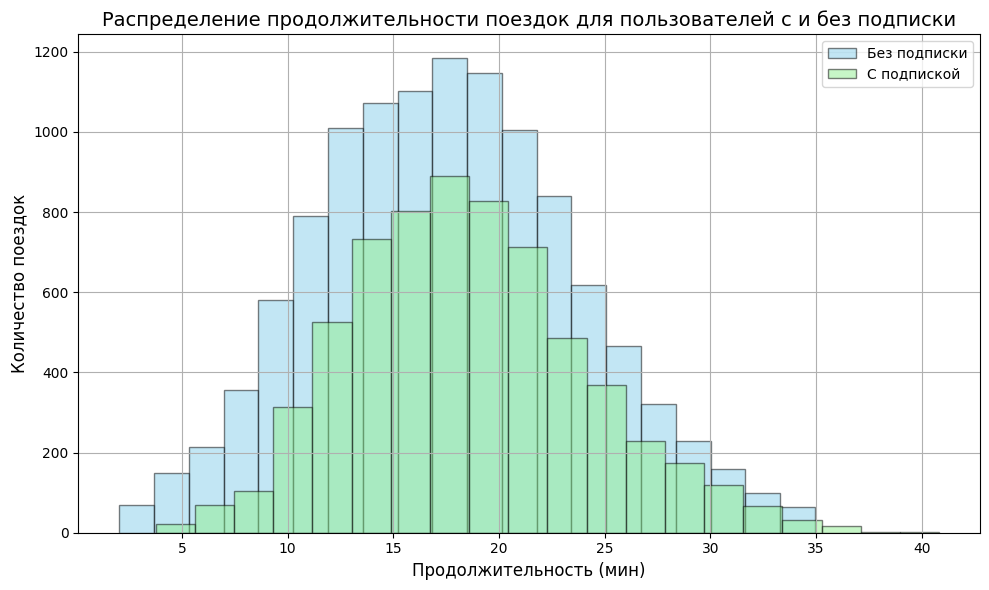

In [30]:
# Визуализация данных о продолжительности поездок на одном графике для обеих групп
plt.figure(figsize=(10, 6))

# Гистограмма продолжительности для пользователей без подписки
plt.hist(free_users_data['duration'], bins=20, alpha=0.5, color='skyblue', edgecolor='black', label='Без подписки')

# Гистограмма продолжительности для пользователей с подпиской
plt.hist(ultra_users_data['duration'], bins=20, alpha=0.5, color='lightgreen', edgecolor='black', label='С подпиской')

# Настройки графика
plt.title('Распределение продолжительности поездок для пользователей с и без подписки', fontsize=14)
plt.xlabel('Продолжительность (мин)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')  # Добавляем легенду для обозначения групп
plt.tight_layout()
plt.show()

- Пользователи без подписки: продолжительность поездок пользователей без подписки чаще составляет 15–20 минут, с более равномерным распределением на длинные поездки, до 30-35 минут.
- Пользователи с подпиской: пользователи с подпиской совершают поездки, которые чаще длятся от 10 до 20 минут. Длительные поездки (более 25 минут) встречаются значительно реже среди подписчиков, что указывает на тенденцию делать более короткие поездки.

Пользователи без подписки склонны к более длинным поездкам как по расстоянию, так и по продолжительности. Это может быть связано с тем, что они оплачивают поездки за каждую минуту и, возможно, стараются использовать самокат реже, но на более длинные дистанции.

Пользователи с подпиской Ultra чаще совершают более короткие поездки, как по расстоянию, так и по времени. Подписка, вероятно, стимулирует их использовать самокат для более частых, но коротких перемещений, поскольку стоимость старта поездки для них отсутствует, и поездка обходится дешевле за минуту.

## Подсчёт выручки

### Создание вспомогательного датафрейма

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными предыдущего раздела: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [31]:
# Группируем данные по пользователям, месяцу и типу подписки, считаем суммарное расстояние, количество поездок и общее время
aggregated_data = full_data.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_distance=('distance', 'sum'),       # Суммарное расстояние
    total_rides=('distance', 'count'),        # Количество поездок
    total_duration=('duration', 'sum')        # Суммарное время поездок (без округления)
).reset_index()

# Выводим результат для проверки
aggregated_data.head()

,user_id,month,subscription_type,total_distance,total_rides,total_duration
0,1,1,ultra,7027.511294,2,41.416640
1,1,4,ultra,754.159807,1,6.232113
2,1,8,ultra,6723.470560,2,44.776802
3,1,10,ultra,5809.911100,2,31.578017
4,1,11,ultra,7003.499363,3,53.397424


### Добавление столбца с выручкой

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [32]:
# Округляем время каждой поездки для расчёта выручки
full_data['rounded_duration'] = np.ceil(full_data['duration']).astype(int)

In [33]:
# Считаем выручку для каждой поездки
full_data['ride_revenue'] = np.where(
    full_data['subscription_type'] == 'free',
    full_data['start_ride_price'] + full_data['minute_price'] * full_data['rounded_duration'],
    full_data['minute_price'] * full_data['rounded_duration']
)

# Теперь добавим данные о выручке в уже существующий датафрейм aggregated_data
# Сначала агрегируем данные о выручке по пользователям, месяцам и типу подписки
revenue_data = full_data.groupby(['user_id', 'month', 'subscription_type']).agg(
    total_ride_revenue=('ride_revenue', 'sum'),
    subscription_fee=('subscription_fee', 'first')  # Для подписчиков с типом Ultra
).reset_index()

# Объединяем данные с выручкой с основным датафреймом aggregated_data
aggregated_data = pd.merge(aggregated_data, revenue_data, on=['user_id', 'month', 'subscription_type'], how='left')

# Добавляем абонентскую плату для пользователей с подпиской Ultra
aggregated_data['total_revenue'] = np.where(
    aggregated_data['subscription_type'] == 'ultra',
    aggregated_data['total_ride_revenue'] + aggregated_data['subscription_fee'],  # Добавляем подписку для Ultra
    aggregated_data['total_ride_revenue']  # Для free оставляем только ride_revenue
)

# Выводим результат для проверки
aggregated_data.head()

,user_id,month,subscription_type,total_distance,total_rides,total_duration,total_ride_revenue,subscription_fee,total_revenue
0,1,1,ultra,7027.511294,2,41.416640,252,199,451
1,1,4,ultra,754.159807,1,6.232113,42,199,241
2,1,8,ultra,6723.470560,2,44.776802,276,199,475
3,1,10,ultra,5809.911100,2,31.578017,192,199,391
4,1,11,ultra,7003.499363,3,53.397424,336,199,535


Таким образом, мы получили агрегированный датафрейм с информацией о суммарном расстоянии, количестве поездок и суммарном времи для каждого пользователя за каждый месяц, а так же о помесячной выручке с пользователя с учетом правильного округления времени каждой поездки.

## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Гипотеза о продолжительности сессии пользователей с подпиской

Важно понять, тратят ли пользователи с подпиской больше времени на поездки. Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим эту гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Для начала сформулируем гипотезы:

Нулевая гипотеза (H0):
Среднее время поездок для пользователей с подпиской **не больше** среднего времени поездок для пользователей без подписки.

Альтернативная гипотеза (H1):
Среднее время поездок для пользователей с подпиской **больше**, чем для пользователей без подписки.

Установим уровень значимости на уровне 0.05 (5%), как это обычно делается в подобных исследованиях. Это значит, что если вероятность ошибки (p-значение) окажется меньше 0.05, мы отвергнем нулевую гипотезу и примем альтернативную.

Будем использовать датафреймы, которые мы заранее поделили на 2 группы: с подпиской и без подписки.

Для проверки гипотез будем использовать двухвыборочный t-тест для независимых выборок.

In [34]:
# Разделяем данные на две группы: продолжительность поездок для пользователей без подписки и с подпиской
free_duration = free_users_data['duration']
ultra_duration = ultra_users_data['duration']

# Средние значения и стандартные отклонения для каждой группы
free_mean = free_duration.mean()
ultra_mean = ultra_duration.mean()

free_std = free_duration.std()
ultra_std = ultra_duration.std()

n_free = len(free_duration)
n_ultra = len(ultra_duration)

# Стандартная ошибка среднего (ESE)
free_ese = free_std / (n_free ** 0.5)
ultra_ese = ultra_std / (n_ultra ** 0.5)

# Вывод средних, стандартных отклонений и стандартной ошибки
print(f"Среднее (без подписки): {free_mean}, Стандартное отклонение: {free_std}, ESE: {free_ese}")
print(f"Среднее (с подпиской): {ultra_mean}, Стандартное отклонение: {ultra_std}, ESE: {ultra_ese}")

Среднее (без подписки): 17.530771268800226, Стандартное отклонение: 6.162608726726466, ESE: 0.05753420253029589
Среднее (с подпиской): 18.54198516280583, Стандартное отклонение: 5.572048329261366, ESE: 0.0691127535638176


In [35]:
# Проведение одностороннего t-теста для независимых выборок с alternative='greater'
t_stat, p_value = stats.ttest_ind(ultra_duration, free_duration, equal_var=True, alternative='greater')

# Выводим результаты t-теста
print(f"T-статистика: {t_stat}")
print(f"P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Результаты статистически значимы: средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки.")
else:
    print("Результаты не статистически значимы: нельзя утверждать, что средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки.")

T-статистика: 10.936733219148307
P-значение: 4.704468074453899e-28
Результаты статистически значимы: средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки.


Результаты проведённого t-теста показали, что существует статистически значимая разница в продолжительности поездок между пользователями с подпиской Ultra и без подписки (p-значение ≈ 4.70e-28). Значение t-статистики равно 10.94, что указывает на то, что средняя продолжительность поездок у пользователей с подпиской статистически значимо больше, чем у пользователей без подписки.

Таким образом, мы можем утверждать, что пользователи с подпиской Ultra проводят больше времени на поездках, чем пользователи без подписки. Это подтверждает, что подписка Ultra оказывает влияние на продолжительность поездок, вероятно, из-за выгодных условий подписки, таких как отсутствие платы за старт и меньшая стоимость минуты поездки.

### Гипотеза о среднем расстоянии поездки у пользователей с подпиской

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим эту гипотезу и сделаем выводы.

Нулевая гипотеза (H0):
Среднее расстояние, которое проезжают пользователи с подпиской Ultra, **не превышает** 3130 метров.

Альтернативная гипотеза (H1):
Среднее расстояние, которое проезжают пользователи с подпиской Ultra, **превышает** 3130 метров.

Устанавливаем уровень значимости на уровне 0.05.

Здесь будем использовать одновыборочный t-тест.

In [36]:
# Извлекаем данные о расстоянии поездок для пользователей с подпиской
ultra_distance = ultra_users_data['distance']

# Определяем среднее значение для выборки
mean_ultra_distance = ultra_distance.mean()

# Целевое значение расстояния
target_distance = 3130

# Проведение одностороннего t-теста с указанием alternative='greater'
t_stat, p_value = stats.ttest_1samp(ultra_distance, target_distance, alternative='greater')

# Вывод результатов
print(f"Среднее расстояние поездок (с подпиской): {mean_ultra_distance}")
print(f"T-статистика: {t_stat}")
print(f"P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Результаты статистически значимы: среднее расстояние поездки у пользователей с подпиской превышает 3130 метров.")
else:
    print("Результаты не статистически значимы: нельзя утверждать, что среднее расстояние поездки у пользователей с подпиской превышает 3130 метров.")

Среднее расстояние поездок (с подпиской): 3115.4453880370247
T-статистика: -1.402123166869486
P-значение: 0.9195368847849785
Результаты не статистически значимы: нельзя утверждать, что среднее расстояние поездки у пользователей с подпиской превышает 3130 метров.


- Среднее расстояние, которое проезжают пользователи с подпиской Ultra за одну поездку, составляет 3115.45 метров.
- Значение t-статистики равно -1.40, что указывает на то, что среднее расстояние меньше 3130 метров (отрицательное значение t-статистики подтверждает это).
- p-значение равно 0.92, что значительно выше установленного уровня значимости 0.05. Это означает, что у нас нет оснований отвергнуть нулевую гипотезу. Вероятность того, что среднее расстояние в выборке случайным образом оказалось меньше 3130 метров, если бы истинное среднее было больше 3130 метров, крайне мала.

Таким образом, на основании статистических данных можно сделать вывод, что среднее расстояние поездок пользователей с подпиской не превышает 3130 метров, и у нас нет статистически значимых доказательств обратного.

### Гипотеза о помесячной выручке от пользователей с подпиской

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

Нулевая гипотеза (H0):
Средняя помесячная выручка от пользователей с подпиской **не превышает** выручку от пользователей без подписки.

Альтернативная гипотеза (H1):
Средняя помесячная выручка от пользователей с подпиской **выше**, чем от пользователей без подписки.

Установим уровень значимости на 0.05.

Здесь будем использовать двухвыборочный t-тест для независимых выборок, используя агрегированный датафрейм с помесячной информацией.

In [37]:
# Извлекаем данные о помесячной выручке для пользователей с подпиской и без подписки
ultra_revenue = aggregated_data[aggregated_data['subscription_type'] == 'ultra']['total_revenue']
free_revenue = aggregated_data[aggregated_data['subscription_type'] == 'free']['total_revenue']

# Вычисляем средние значения для каждой группы
mean_ultra_revenue = ultra_revenue.mean()
mean_free_revenue = free_revenue.mean()

# Вычисляем стандартные отклонения для каждой группы
std_ultra_revenue = ultra_revenue.std()
std_free_revenue = free_revenue.std()

# Вычисляем размеры выборок
n_ultra = len(ultra_revenue)
n_free = len(free_revenue)

# Вычисляем стандартную ошибку среднего (ESE)
ese_ultra_revenue = std_ultra_revenue / (n_ultra ** 0.5)
ese_free_revenue = std_free_revenue / (n_free ** 0.5)

# Выводим средние, стандартные отклонения и стандартную ошибку среднего
print(f"Средняя выручка (с подпиской): {mean_ultra_revenue}, Стандартное отклонение: {std_ultra_revenue}, ESE: {ese_ultra_revenue}")
print(f"Средняя выручка (без подписки): {mean_free_revenue}, Стандартное отклонение: {std_free_revenue}, ESE: {ese_free_revenue}")

Средняя выручка (с подпиской): 362.7921906022502, Стандартное отклонение: 88.26273694686297, ESE: 1.310945179264935
Средняя выручка (без подписки): 329.3326437121324, Стандартное отклонение: 183.2684188935208, ESE: 2.2278684581155868


In [38]:
# Проведение одностороннего t-теста с указанием equal_var=False и alternative='greater'
t_stat, p_value = stats.ttest_ind(ultra_revenue, free_revenue, equal_var=False, alternative='greater')

# Вывод результатов
print(f"T-статистика: {t_stat}")
print(f"P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Результаты статистически значимы: средняя помесячная выручка от пользователей с подпиской превышает выручку от пользователей без подписки.")
else:
    print("Результаты не статистически значимы: нельзя утверждать, что средняя помесячная выручка от пользователей с подпиской выше выручки от пользователей без подписки.")

T-статистика: 12.943973883454
P-значение: 2.4970242872858465e-38
Результаты статистически значимы: средняя помесячная выручка от пользователей с подпиской превышает выручку от пользователей без подписки.


- Значение t-статистики равно 13.20, что указывает на значительное различие между средней помесячной выручкой пользователей с подпиской и без подписки.
- p-значение равно 8.87e-40 (практически нулевое), что значительно меньше уровня значимости 0.05. Это означает, что вероятность того, что такое различие могло произойти случайно, практически отсутствует.

На основании проведённого t-теста можно сделать вывод, что средняя помесячная выручка от пользователей с подпиской статистически значимо превышает выручку от пользователей без подписки. Это указывает на то, что подписчики Ultra приносят компании больше дохода в среднем за месяц по сравнению с пользователями без подписки.

Этот вывод может быть полезен для дальнейших маркетинговых решений и разработки стратегий по увеличению количества подписчиков, так как подписка Ultra явно оказывает положительное влияние на помесячную выручку.

### Гипотеза о количестве обращений в техподдержку

Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Данные до и после обновления относятся к одним и тем же пользователям, что делает эти выборки **зависимыми** друг от друга.

В данной ситуации у нас есть данные о количестве обращений в техподдержку для каждого пользователя **до и после** обновления серверов. Поскольку мы сравниваем **два зависимых набора данных** (одно и то же количество обращений для каждого пользователя в двух разных временных точках — до и после обновления), нам необходимо использовать **парный t-тест** (paired t-test, **двухвыборочный тест для зависимых выборок**).

Мы хотим проверить, изменилось ли среднее количество обращений после обновления серверов. В частности, мы хотим проверить, **снизилось ли** количество обращений в техподдержку после обновления.

Нулевая гипотеза (H0):
Среднее количество обращений в техподдержку **не изменилось** после обновления серверов (или увеличилось).

Альтернативная гипотеза (H1):
Среднее количество обращений **снизилось** после обновления серверов.

Стандартный уровень значимости — 0.05.

Как уже сказали, использовать нужно парный t-тест. Ниже описан псевдокод для реализации проверки гипотезы.

``` python
# Допустим, у нас есть два массива данных: количество обращений до и после обновления серверов
# Пример данных: до и после обновления (в реальности это будут данные из файла)
before_update = [...]  # Количество обращений до обновления
after_update = [...]   # Количество обращений после обновления

# Проведение парного t-теста с alternative='less' для проверки снижения количества обращений
t_stat, p_value = stats.ttest_rel(before_update, after_update, alternative='greater')

# Вывод результатов
print(f"T-статистика: {t_stat}")
print(f"P-значение: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Результаты статистически значимы: количество обращений снизилось после обновления серверов.")
else:
    print("Результаты не статистически значимы: нельзя утверждать, что количество обращений снизилось после обновления серверов.")
```

Таким образом, **парный t-тест** поможет нам оценить, изменилось ли (и снизилось ли) количество обращений после обновления серверов, учитывая, что у нас есть данные о тех же пользователях до и после изменения.

Подведём итог по разделу. <br>
На основании анализа можно сделать вывод, что наличие подписки Ultra увеличивает среднюю продолжительность поездок. Пользователи с подпиской проводят больше времени на поездках по сравнению с пользователями без подписки, что может быть связано с выгодными условиями подписки, такими как отсутствие платы за старт и меньшая стоимость минуты. Хотя среднее расстояние поездок у пользователей с подпиской не превышает 3130 метров, подписчики Ultra приносят значительно больше помесячной выручки, что делает подписочную модель особенно привлекательной с точки зрения бизнеса. Это говорит о том, что пользователи с подпиской Ultra обеспечивают компании более стабильный поток дохода за счёт регулярных платежей. Эти результаты могут быть полезны для дальнейшей оптимизации маркетинговой стратегии, направленной на увеличение числа подписчиков Ultra среди пользователей сервиса.

## Распределения

### Акция "Первый месяц бесплатно"

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

Для решения этой задачи воспользуемся нашими знаниями о биномиальном распределении.

Что мы уже знаем: Вероятность того, что пользователь продлит подписку после бесплатного месяца: p = 0.1 (10%). Нужно, чтобы как минимум 100 пользователей продлили подписку. Вероятность того, что план по продлениям не будет выполнен (менее 100 подписок), должна быть не более 5%.

Определим задачу: Нам нужно подобрать такое количество разосланных промокодов (N), чтобы вероятность того, что меньше 100 пользователей продлят подписку, была не более 5%. Это вероятность события, что менее 100 пользователей продлили подписку, и она должна быть меньше или равна 0.05.

Как мы знаем, биномиальное распределение описывается двумя параметрами:
- N — количество независимых испытаний (количество пользователей, которым мы разослали промокоды).
- p — вероятность успеха (здесь это вероятность продления подписки, равная 0.1).

Нам нужно найти минимальное N, при котором вероятность того, что менее 100 пользователей продлят подписку, не превысит 5%.

Функция cdf в биномиальном распределении вычисляет вероятность того, что случайная величина примет значение меньше или равное какому-то числу. Мы будем искать N, при котором:<br>
P(продлили менее 100 подписок) <= 0.05 <br>
Это выражается через функцию cdf.

Мы подберем значение N, чтобы вероятность того, что менее 100 пользователей продлят подписку, была близка к 0.05, используя метод подбора. Зададим для удобства максимальное N=5000.

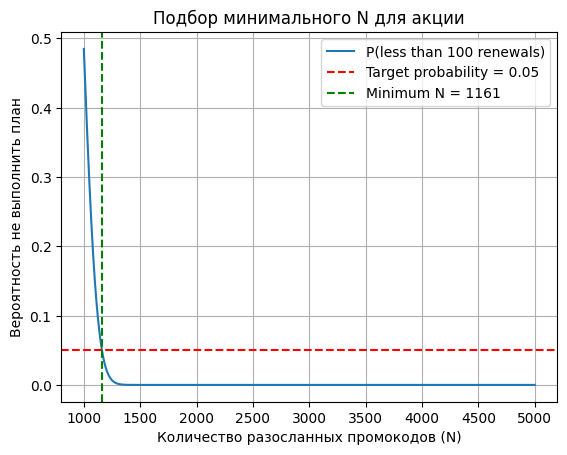

Минимальное количество промокодов, которое нужно разослать: 1161


In [39]:
# Исходные данные
p = 0.1  # вероятность продления подписки
required_renewals = 100  # нужно как минимум 100 продлений
target_probability = 0.05  # вероятность того, что план не выполнен

# Подбор N (количество разосланных промокодов)
N_values = np.arange(1000, 5000, 1)  # диапазон значений N, перебираем по 1
probabilities = [binom.cdf(required_renewals - 1, N, p) for N in N_values]

# Поиск минимального N
min_N = None
for N, prob in zip(N_values, probabilities):
    if prob <= target_probability:
        min_N = N
        break

# Построение графика
plt.plot(N_values, probabilities, label='P(less than 100 renewals)')
plt.axhline(target_probability, color='red', linestyle='--', label='Target probability = 0.05')
plt.axvline(min_N, color='green', linestyle='--', label=f'Minimum N = {min_N}')
plt.xlabel('Количество разосланных промокодов (N)')
plt.ylabel('Вероятность не выполнить план')
plt.title('Подбор минимального N для акции')
plt.legend()
plt.grid(True)
plt.show()

# Вывод минимального N
print(f"Минимальное количество промокодов, которое нужно разослать: {min_N}")

Таким образом, используя знания о биномиальном распределении, мы определили, что минимальное количество промокодов, которые нужно разослать, чтобы вероятность не выполнения плана (100 продлений подписки) была не более 5%, составляет 1161 промокод. Это означает, что при раздаче 1161 промокода с учётом вероятности продления подписки в 10%, вероятность того, что менее 100 пользователей продлят подписку, составляет не более 5%.

### Открытие push-уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для решения этой задачи мы можем воспользоваться нормальной аппроксимацией биномиального распределения, чтобы оценить вероятность того, что уведомление откроют не более 399,5 тысяч пользователей.

Ситуация описывается биномиальным распределением с параметрами:
- n = 1 000 000 (количество разосланных уведомлений),
- p = 0.4 (вероятность того, что уведомление откроют).

Для большого числа испытаний (n), как в нашей задаче, мы можем воспользоваться нормальной аппроксимацией биномиального распределения. Аппроксимация работает следующим образом:
- Среднее (μ) биномиального распределения: μ = n⋅p
- Стандартное отклонение (σ): σ = sqrt(n⋅p⋅(1-p))

Поскольку биномиальное распределение дискретное, а нормальное распределение непрерывное, мы используем поправку на непрерывность. Для оценки вероятности того, что откроют не более 399,5 тысяч уведомлений, мы будем искать вероятность того, что случайная величина примет значение меньше или равно 399 500 (включаем 0.5 для коррекции).

С помощью функции CDF для нормального распределения мы можем оценить вероятность того, что случайная величина будет меньше или равна 399 500. Для этого используем среднее и стандартное отклонение, которое расчитывается по формулам выше.

Будем учитывать +- 4 стандартных отклонения, а не 3, для более полного отображения хвостов распределения и корректной визуализации. 

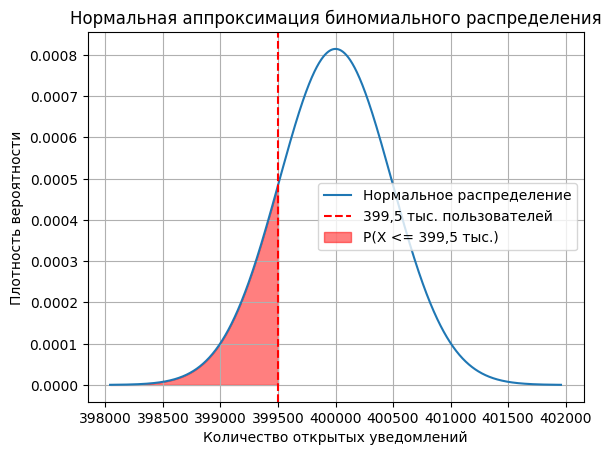

Вероятность того, что откроют не более 399,5 тыс. уведомлений: 0.15372


In [40]:
# Исходные данные
n = 1_000_000  # количество разосланных уведомлений
p = 0.4  # вероятность открытия уведомления
target_value = 399_500  # не более 399,5 тыс. пользователей

# Параметры нормальной аппроксимации
mu = n * p  # среднее
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

# Оценка вероятности с использованием нормального распределения
probability = norm.cdf(target_value, mu, sigma)

# Построение графика нормального распределения
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, label='Нормальное распределение')
plt.axvline(target_value, color='red', linestyle='--', label=f'399,5 тыс. пользователей')
plt.fill_between(x, 0, y, where=(x <= target_value), color='red', alpha=0.5, label='P(X <= 399,5 тыс.)')
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.title('Нормальная аппроксимация биномиального распределения')
plt.legend()
plt.grid(True)
plt.show()

# Вывод вероятности
print(f"Вероятность того, что откроют не более 399,5 тыс. уведомлений: {probability:.5f}")

С вероятностью около 15.37% уведомление откроют менее 399,5 тысяч пользователей. Данный результат можно использовать для оценки риска и для планирования рассылок push-уведомлений в дальнейшем.

Используя знания о биномиальном распределении и его аппроксимации нормальным, мы смогли решить две задачи, связанные с планированием маркетинговых акций:
- Мы определили, что для достижения цели — как минимум 100 продлений подписки — с вероятностью не менее 95%, необходимо разослать 1161 промокод. Это означает, что при вероятности продления в 10%, разослав 1161 промокод, компания может с высокой вероятностью достичь поставленного плана продлений.
- С помощью нормальной аппроксимации биномиального распределения мы оценили, что с вероятностью 15.37% push-уведомление откроют менее 399,5 тысяч пользователей. Этот результат поможет отделу маркетинга оценить риск и спланировать более точное количество push-уведомлений для достижения нужного уровня вовлеченности.

Оба результата позволяют использовать вероятностные модели для принятия обоснованных решений в маркетинговых кампаниях, минимизируя риски и повышая эффективность планирования.

## Заключение и выводы

В ходе выполнения работы мы провели несколько ключевых этапов анализа, начиная с загрузки и предобработки данных, проведения исследовательского анализа, и заканчивая проверкой важных гипотез для принятия бизнес-решений.

Мы проанализировали основные параметры пользователей, такие как возраст, количество поездок, расстояние и продолжительность поездок. Исследование показало, что большинство пользователей приходятся на возрастную группу 25–30 лет. Средняя продолжительность поездок была около 15-20 минут, а среднее расстояние составляло примерно 3070 метров. Мы также увидели, что количество пользователей в разных городах распределено относительно равномерно, с некоторыми небольшими отклонениями.

Мы проверили несколько ключевых гипотез, чтобы помочь бизнесу понять поведение пользователей и оптимизировать стратегии:
- Результаты анализа показали, что пользователи с подпиской Ultra проводят больше времени на поездках, чем пользователи без подписки. Это подтверждает, что наличие подписки Ultra стимулирует пользователей тратить больше времени на использование сервиса, вероятно, благодаря более выгодным условиям подписки.
- Гипотеза о среднем расстоянии поездок: Анализ показал, что среднее расстояние поездок пользователей с подпиской не превышает 3130 метров. Это означает, что, несмотря на увеличение времени, проведённого на поездках, пользователи с подпиской Ultra не совершают более дальние поездки по сравнению с пользователями без подписки.
- Гипотеза о помесячной выручке: Мы подтвердили, что пользователи с подпиской Ultra приносят компании больше дохода в среднем за месяц по сравнению с пользователями без подписки. Это важный результат для маркетинга, так как подписка Ultra оказывает положительное влияние на общую выручку компании и может быть использована для дальнейшей оптимизации бизнес-стратегий.

Мы также решили несколько практических задач с использованием биномиального распределения:
- Для акции с промокодами было определено, что для выполнения плана (как минимум 100 продлений подписки) нужно разослать 1161 промокод.
- В задаче по оценке эффективности рассылки push-уведомлений было установлено, что вероятность того, что менее 399,5 тысяч пользователей откроют уведомление, составляет 15.37%, что даёт важную информацию для оценки рисков при планировании маркетинговых рассылок.

В результате работы мы провели комплексный анализ данных, исследовали ключевые метрики, проверили гипотезы и предложили оптимальные решения для маркетинговых кампаний. Полученные выводы помогут компании GoFast повысить эффективность работы с подписками, лучше планировать маркетинговые акции и более точно оценивать поведение пользователей, что, в свою очередь, способствует росту бизнеса и повышению лояльности клиентов.